# Introduction

## Motivation

One of the most controversial design choices of Python is the use of dynamic types. Dynamic types of variables can often lead to confusion for beginners, but even for experts it is a common source of hard-to-find bugs. For this reason the concept of type annotations has been introduced later in the language to allow for static code analysis and more detailed source code documentation. However, type annotations are not enforced by the Python interpreter and therefore do not prevent the user from passing the wrong type of data to a function or class. This can lead to delayed code failure, bad user experiences, and difficult-to-find bugs.

### **Example 1**: Dynamic typing can lead to unexpected behavior

For beginners the dynamic typing of Python can be a source of confusion. Consider the following example:

In [ ]:
def my_function(x):
    return 2 * x


# Expected behaviour
print(my_function(3))

# Half-Expected behaviour
print(my_function(3.14))

Now we call the same method with a different type of argument:

In [ ]:
# Possibly unexpected behaviour
print(my_function("hello"))

In [ ]:
# Maybe even mor unexpected behaviour
print(my_function(x=True))

Now let's define a different fucntion, which naively does the same as before:

In [ ]:
def my_other_function(x):
    return 2.0 * x


# Now try this
print(my_other_function("hello"))

Python will "happily" execute the calls to `my_function`, but the result is possibly un-expected. In contrast the call to `my_other_function` fails. The reason is that the `*` operator is overloaded for strings / bools and integers, but not for strings and floats. This behaviour is built into the Python language and cannot really be changed. 

### **Example 2**: Delayed code failure with non-validated input data

In this example we read an example input YAML file, which contains temperature data. The data is then used to calculate the average temperature. However, the input data is not validated and therefore the code will fail at a later point in time.

In [ ]:
import yaml


def parse_data_into_lists(data):
    """Parse data into lists of values"""
    temperature = [_["temperature"] for _ in data]
    time = [_["time"] for _ in data]
    return {
        "temperature": temperature,
        "time": time,
    }


with open("my-data.yaml", "r") as fh:
    data = yaml.safe_load(fh)

processed = parse_data_into_lists(data=data)

# Compute mean
mean = sum(processed["temperature"]) / len(processed["temperature"])

This is especially annoying if the code is part of a larger application and the reading and processing takes time.

### **Example 3**: A "stupid bug" example (happend to everyone in the past...)

One last example is of the category "stupid bug": this includes typos, incorrect use of APIs and other mistakes that are easy to make and sometimes hard to find, often only by close inspection of the code. 

In [ ]:
from matplotlib import pyplot as plt

x = [1, 2, 3, 4, 5]
y = [my_function(i) for i in x]

plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim = (0, 6)  # Searching for half an hour why the plot has the wrong limits

In [ ]:
plt.xlim(0, 6)  # Now trying to correct in the notebook...ops even more confusing...

### Refresher 2: Class Definitions

Quick survey:
- Who knows what class definitions are?
- Who is using class definitions regularly?
- Who would like to use class definitons more, but is not doing it yet?


Recall that classes in Python are defined with the `class` keyword followed by the name of the class (usually capitalized) and a colon. Class and instance methods are defined inside the class by indenting once. Let's create a simple class to represent a two dimensional point coordinate. We will add "V1" to the end of the class name so that we can make improvements later ("V2", "V3", etc.) and compare versions.

In [ ]:
class PointV1:
    """Representation of a two-dimensional point coordinate."""

    def __init__(self, x, y):
        """Initializes a PointV1 with the given coordinates."""
        self.x = x
        self.y = y

    def distance_to(self, other):
        """Computes the distance to another `PointV1`."""
        dx = self.x - other.x
        dy = self.y - other.y
        return (dx**2 + dy**2) ** 0.5

This class definition is correct and will behave as expected, assuming the user knows how to use the class properly. But this class suffers from two problems:

First, users of this class may be able to understand that `x` and `y` are intended to be integers or floats. But they would need to look at the code in order to come to this conclusion and this may be difficult for more complex classes. This can be improved by modifying the docstrings to include the intended argument types, but we will soon see an even better way to show the user the intended argument and output types.

Secondly, your IDE will not understand the intended argument and output types and thus will not highlight bugs such as the following:

In [ ]:
p1 = PointV1(x="5", y="7")

Of course the user will discover the bug when attempting to compute the distance to another `PointV1`:

In [ ]:
p2 = PointV1(x=-1, y=4)

p1.distance_to(p2)

But it would be nice if your code editor (IDE) could highlight this mistake for you before even executing a single line of code.

### Refresher 2: Type Annotations

Introduced in Python 3.5, [type annotations](https://docs.python.org/3/library/typing.html) (also known as type hints) provide a mechanism to solve both problems simultaneously. 

Quick survey:
- Who knows what type annotations are?
- Who is using type annotations regularly?
- Who would like to use type annotations more, but is not doing it yet?

Intended types can be supplied after an argument or variable by separating the two with a colon. And output types can by supplied after the closing parenthesis and before the colon with an arrow `->`. Let's improve the `PointV1` class with type annotations.

In [ ]:
class PointV2:
    """Representation of a two-dimensional point coordinate."""

    def __init__(self, x: float, y: float) -> None:
        """Initializes a PointV2 with the given coordinates."""
        self.x = x
        self.y = y

    def distance_to(self, other: "PointV2") -> float:
        """Computes the distance to another `PointV2`."""
        dx = self.x - other.x
        dy = self.y - other.y
        return (dx**2 + dy**2) ** 0.5

The first problem is solved by clearly indicating the expected argument and output types. `x` and `y` are marked as `float` indicating that the user should provide `floats` for these arguments. The output of `__init__` is marked as `None` indicating that there is no value returned by this method. `other` is marked as `"PointV2"` to indicate that the the argument supplied to `distance_to` should be another `PointV2`. Note the quotes around `"PointV2"` because the `PointV2` class is not fully defined until after the body of the `PointV2` class. Most modern IDEs will understand that `"PointV2"` means `PointV2`. And the output of `distance_to` is marked as `float` to indicate that the output should a float.

One other note is that `self` is not given any type hints. This is convention and modern IDEs will understand that `self` is a reference to an instance of `PointV2`.

The second problem is solved because now your IDE will understand if you have a bug like the one above. For example, PyCharm will warn you by highlighting the offending pieces of code as in the following screen shot:

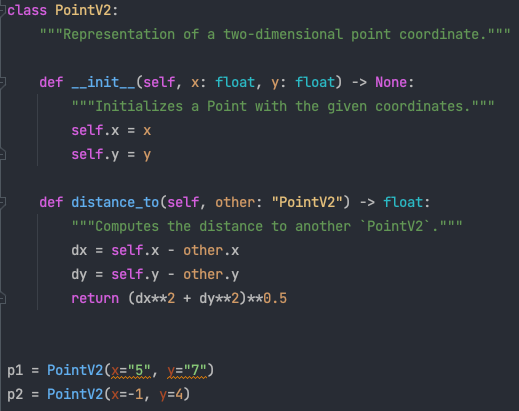

Notice the orange squiggly lines under `x="5"` and `y="7"` in the creation of `p1` and the lack of yellow squiggly lines under `x=-1` and `y=4` in the creation of `p2`.

You can also use a tool such as [mypy](https://mypy-lang.org) to check the types of your code. Let's check the code in the example `my-script.py`:

In [ ]:
!cat my-script.py

In [ ]:
!mypy my-script.py

However it is important to repeat that type annotations are not enforced by the Python interpreter, but are typically only  used by external tools to perform static code analysis.

### Refresher 3: Data Classes and "Friends"

There is another small problem with the class definitions we introduced above: it includes a lot of so called ["Boilerplate Code"](https://en.wikipedia.org/wiki/Boilerplate_code). This is code that is just required to make the defintion work and does not add any functionality. In this case the boilerplate code is the `__init__` method. This method is required to initialize the class, but it does not add any functionality.

 In fact, the `__init__` method is so common that Python introduced various shortcuts in the standard library to simplfy the definiton of such data structures. The most common ones are:
 
 - the `dataclass` decorator
 - the `namedtuple` method
 - the `TypedDict` type


 Quick survey:
  - Who has used `dataclass`, `namedtuple` or `TypedDict` before?


Let's write the Point class, but this time using the `dataclass` decorator:

In [ ]:
from dataclasses import dataclass


@dataclass
class PointV3:
    """Representation of a two-dimensional point coordinate."""

    x: float
    y: float

    def distance_to(self, other: "PointV3") -> float:
        """Computes the distance to another `PointV3`."""
        dx = self.x - other.x
        dy = self.y - other.y
        return (dx**2 + dy**2) ** 0.5

This allows to simplify the class definition and skip the definiton of the `__init__` method.

In [ ]:
p1 = PointV3(x=5, y=7)
p2 = PointV3(x=-1, y=4)
print(p1.distance_to(other=p2))

There are similar concepts to `dataclass`, such as `namedtuple`, which allows to define a class with a fixed set of attributes:

In [ ]:
from collections import namedtuple

PointV4 = namedtuple("PointV4", "x y")

p1 = PointV4(x=5, y=7)

display(p1)

However they have very specific use cases and are not as flexible as `dataclass`. For example, `namedtuple` does not directly allow to define methods and attributes are immutable:

In [ ]:
p1.x = 64

Another variation is to use a `TypedDict` to define a class with a fixed set of attributes:

In [ ]:
from typing import TypedDict


class PointV5(TypedDict):
    x: float
    y: float

However this is used in a rather unconventional way:

In [ ]:
p1: PointV5 = {"x": 5, "y": 7}

And as with the other classes, the types are not enforced during runtime, such that they can be changed anytime later:

In [ ]:
p1["x"] = "34"

The `TypedDict` is again mostly useful for static code analysis, in which case the statement above would be highlighted as an error. 

All these limitations and issues listed above can be addressed with the [pydantic](https://pydantic-docs.helpmanual.io/) library. This library allows to define data classes with type annotations and to validate the input data against the type annotations.

## Exercise 1:

- Just take some time to briefly discuss with your neighbours the examples where dynamic typing leads to unexpected behaviour. Have you encountered similar issues in the past? How did you solve them? 
- Also take some time to dicuss the concepts of type annotations, class definitions and data classes we reviewed above. Have you used them in the past? What are your experiences? 